In [3]:
import numpy as np
import torch
from utils import plot_graph

In [4]:
def make_flow_graph(size, freedom=None):
    freedom = freedom or 2 / np.sqrt(size)
    sample = torch.distributions.chi2.Chi2(freedom).sample((size, size))
    return torch.tril(torch.round(sample), -1).T

In [262]:
def solve_max_flow(capacity):
    # Define the variables with initial values and set requires_grad=True for optimization
    fflow = torch.rand_like(capacity, requires_grad=True)

    # Define the penalty weight
    penalty_weight = 2137.0

    # Define the optimizer
    optimizer = torch.optim.SGD([fflow], lr=0.01)

    # Objective function with penalty terms
    def objective(intensity):
        flow = fflow * (capacity != 0).float()

        # Original objective function: total flow to the sink
        obj = flow[:, -1].sum()

        # Penalty for capacity constraints
        capacity_penalty = intensity * torch.sum(torch.relu(flow - capacity) ** 2)

        # Penalty for non-negativity constraints
        nonnegativity_penalty = intensity * torch.sum(torch.relu(-flow) ** 2)

        flow_conservation_penalty = intensity * torch.sum(
            (flow[:, 1:-1].sum(axis=0) - flow[1:-1, :].sum(axis=1)) ** 2
        )
        # Total objective with penalties
        total_objective = obj - penalty_weight * (
            capacity_penalty + nonnegativity_penalty + flow_conservation_penalty
        )

        return total_objective

    # Training loop
    num_iterations = 20000
    flow_values = []
    objective_values = []

    for iteration in range(num_iterations):
        optimizer.zero_grad()
        loss = -objective(
            intensity=(iteration + 1) / num_iterations
        )  # We minimize the negative objective to maximize the original objective
        loss.backward()

        # Clip gradients to have norm less than 0.1
        torch.nn.utils.clip_grad_norm_([fflow], max_norm=0.1)

        optimizer.step()

        # Record the flow values and objective
        # flow_values.append(flow)
        # objective_values.append(objective(intensity=1).item())

        if iteration % 1000 == 0:
            print("*" * 50)
            # Print the results
            print(f"Iteration {iteration}:")
            # print(fflow.detach().numpy().mean())
            plot_graph(np.around(fflow.detach(), decimals=2), capacity)
            print(f"Objective value: {objective(intensity=1).item()}")

In [336]:
def make_flow_network(size, paths=3):
    net = torch.zeros((size, size))
    for i in np.zeros(paths, dtype=int):
        while i < size - 1:
            net[i][i := np.random.randint(i + 1, size)] += np.random.randint(1, 5)
    return net

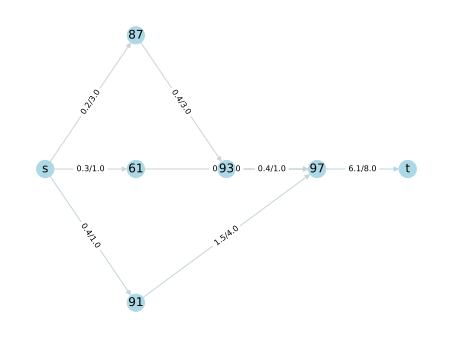

In [337]:
import networkx as nx

capacity = make_flow_network(99, paths=3)
flow = (torch.rand_like(capacity) * capacity).requires_grad_()
plot_graph(flow, capacity)

**************************************************
Iteration 0:


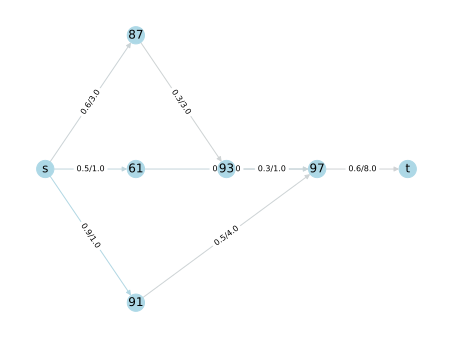

Objective value: -2474.8603515625
**************************************************
Iteration 1000:


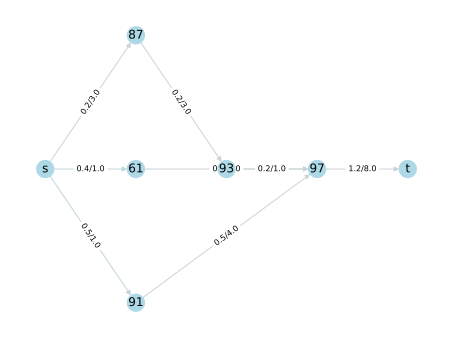

Objective value: 1.1642780303955078
**************************************************
Iteration 2000:


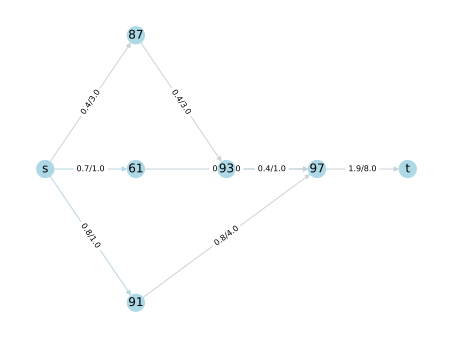

Objective value: 1.8589993715286255
**************************************************
Iteration 3000:


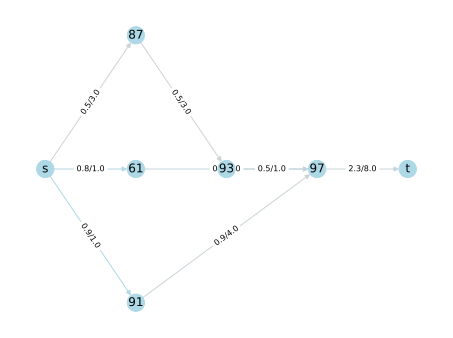

Objective value: 2.2915384769439697
**************************************************
Iteration 4000:


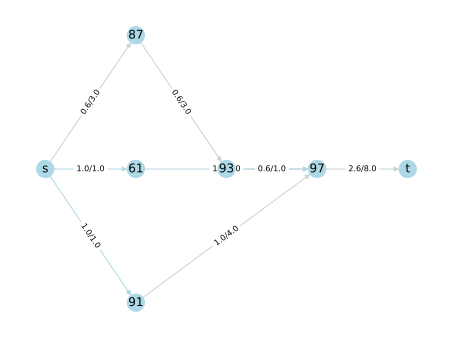

Objective value: 2.5765819549560547
**************************************************
Iteration 5000:


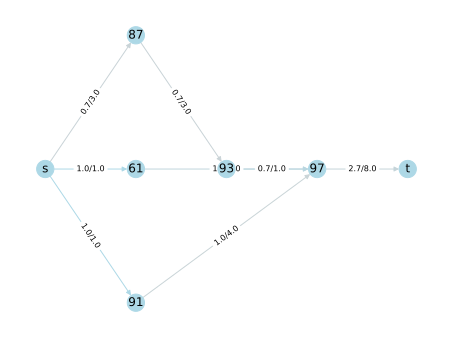

Objective value: 2.7014453411102295
**************************************************
Iteration 6000:


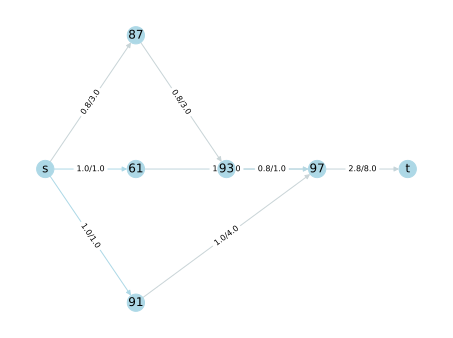

Objective value: 2.7869348526000977
**************************************************
Iteration 7000:


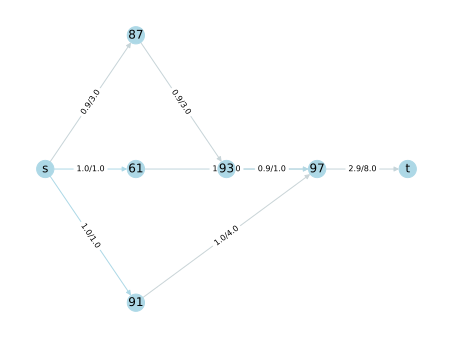

Objective value: 2.858832597732544
**************************************************
Iteration 8000:


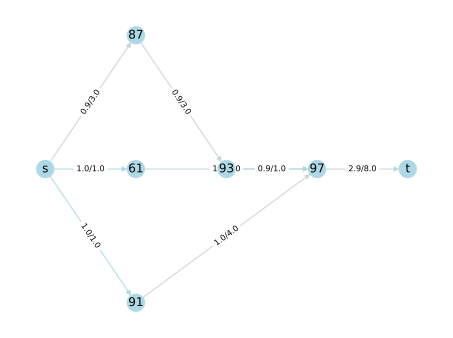

Objective value: 2.9209117889404297
**************************************************
Iteration 9000:


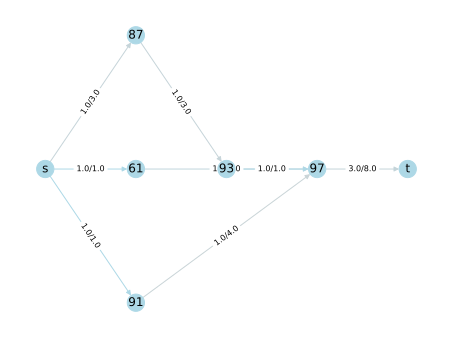

Objective value: 2.975560426712036
**************************************************
Iteration 10000:


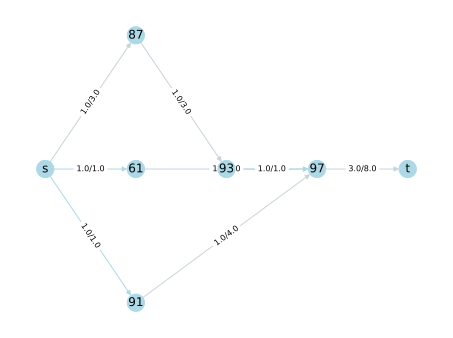

Objective value: 2.996946334838867
**************************************************
Iteration 11000:


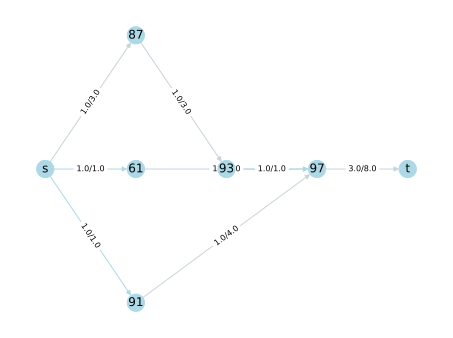

Objective value: 2.9973952770233154
**************************************************
Iteration 12000:


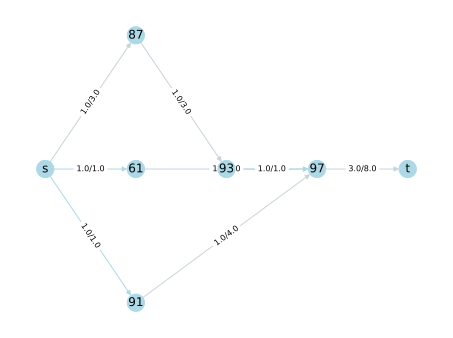

Objective value: 2.9977328777313232
**************************************************
Iteration 13000:


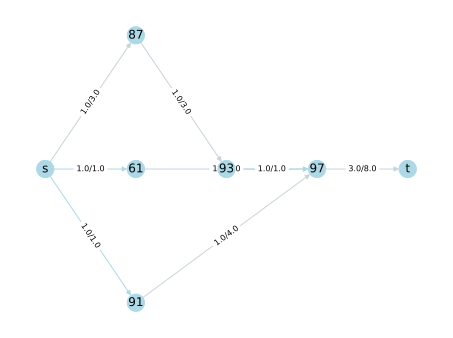

Objective value: 2.997838258743286
**************************************************
Iteration 14000:


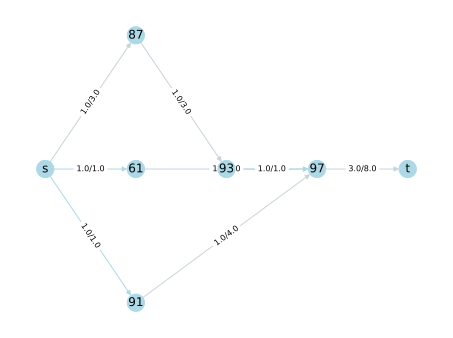

Objective value: 2.997737407684326
**************************************************
Iteration 15000:


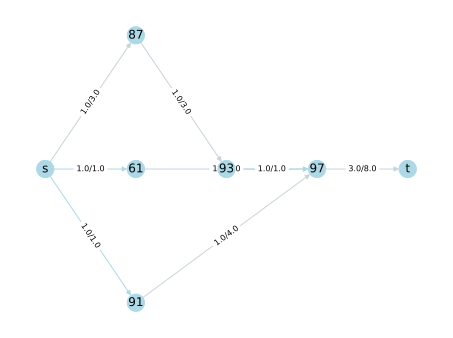

Objective value: 2.9974896907806396
**************************************************
Iteration 16000:


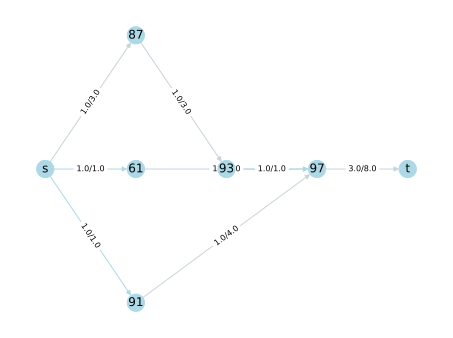

Objective value: 2.997454881668091
**************************************************
Iteration 17000:


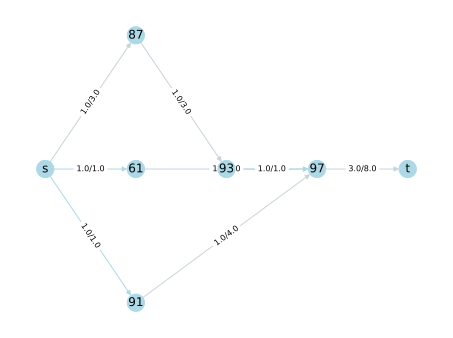

Objective value: 2.9977195262908936
**************************************************
Iteration 18000:


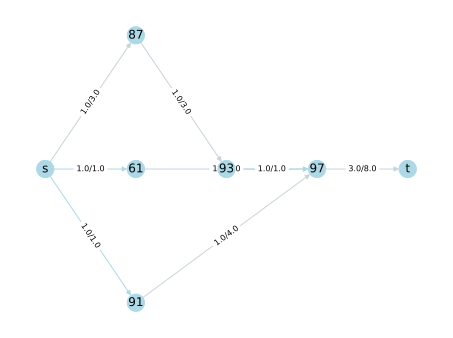

Objective value: 2.9980576038360596
**************************************************
Iteration 19000:


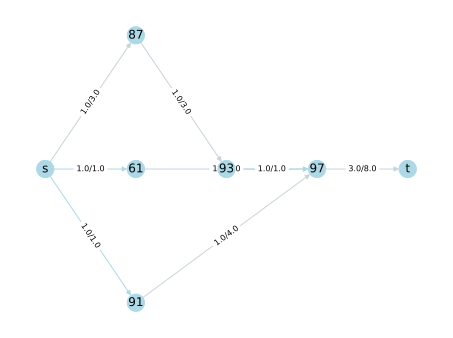

Objective value: 2.9983396530151367


In [338]:
solve_max_flow(capacity)